In [37]:
import numpy as np
import pandas  as pd
import seaborn as sea
import matplotlib.pyplot as plt
import glob
paths = sorted(glob.glob(f'datasets/Cryptocurrency Historical Prices/*.csv'))

In [38]:
dicionario = {'Csv':[],'Instancias':[]}
for i in range(len(paths)):
    dicionario['Csv'].append(paths[i].split('/')[2])
    dicionario['Instancias'].append(pd.read_csv(paths[i]).shape[0])

In [39]:
grupos = pd.DataFrame(dicionario)
grupos

,Csv,Instancias
0,coin_Aave.csv,275
1,coin_BinanceCoin.csv,1442
2,coin_Bitcoin.csv,2991
3,coin_Cardano.csv,1374
4,coin_ChainLink.csv,1385
5,coin_Cosmos.csv,845
6,coin_CryptocomCoin.csv,935
7,coin_Dogecoin.csv,2760
8,coin_EOS.csv,1466
9,coin_Ethereum.csv,2160


In [40]:
g1 = grupos.loc[grupos['Instancias']>2000]
g1

,Csv,Instancias
2,coin_Bitcoin.csv,2991
7,coin_Dogecoin.csv,2760
9,coin_Ethereum.csv,2160
11,coin_Litecoin.csv,2991
12,coin_Monero.csv,2602
13,coin_NEM.csv,2288
16,coin_Stellar.csv,2527
17,coin_Tether.csv,2318
22,coin_XRP.csv,2893


In [41]:
g2 = grupos.loc[(grupos['Instancias']>800) & (grupos['Instancias']<1000)] 
g2

,Csv,Instancias
5,coin_Cosmos.csv,845
6,coin_CryptocomCoin.csv,935
21,coin_WrappedBitcoin.csv,888


In [42]:
g3 = grupos.loc[(grupos['Instancias']<800)] 
g3

,Csv,Instancias
0,coin_Aave.csv,275
14,coin_Polkadot.csv,320
15,coin_Solana.csv,452
20,coin_Uniswap.csv,292


Farei a divisão de 3 grupos 
1. $>$ 2000 instancias
2. $>$ 800 & $<$ 1000 instancias
3. $<$ 800
> Para eviter viés

In [43]:
def Concats( paths , gn ):
    data = pd.DataFrame()
    for path in paths:
        for nomes in gn:
            if nomes in path:
                data =pd.concat([data, pd.read_csv(path)], ignore_index=True)
    return data
        

In [44]:
dataset = Concats(paths,g1['Csv'].values)
dataset.head(3)

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000,116.989998,0.0,1.298955e+09


In [45]:
dataset['Symbol'].nunique()

9

In [46]:
dataset.shape

(23530, 10)

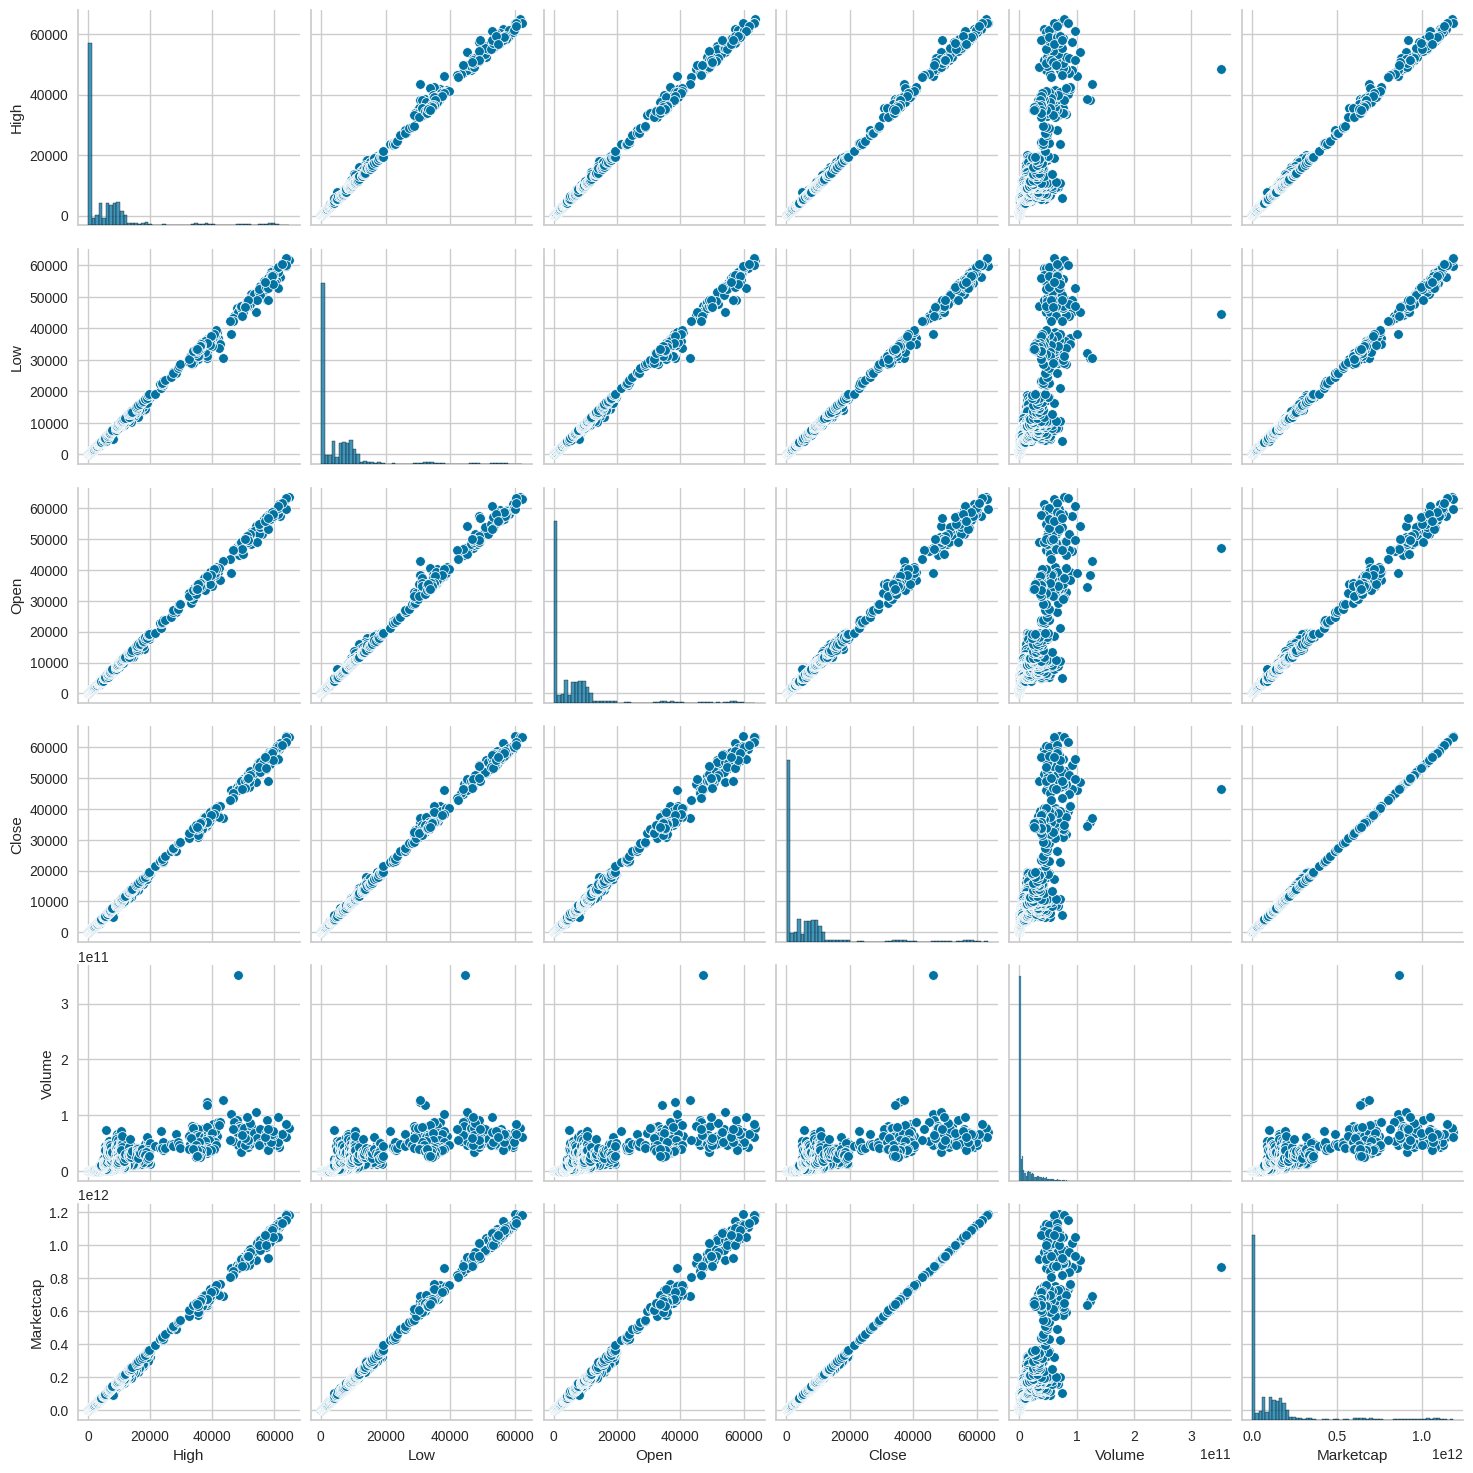

In [47]:
coluna = dataset['Symbol'].drop_duplicates()[0]
sea.pairplot(dataset.loc[dataset['Symbol']==coluna].select_dtypes(include='float'),hue_order='Marketcap')
plt.show()

&nbsp;

In [48]:
from sklearn.preprocessing   import LabelEncoder,StandardScaler,MinMaxScaler
from sklearn.base            import BaseEstimator,TransformerMixin
from sklearn.pipeline        import Pipeline
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    KFold,
    StratifiedShuffleSplit
    )
from sklearn.metrics import *
from sklearn.compose import TransformedTargetRegressor

In [49]:
from sklearn.linear_model import ElasticNet,Ridge,SGDRegressor
from sklearn.ensemble     import GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor
from sklearn.tree         import DecisionTreeRegressor

In [50]:
from yellowbrick.regressor import PredictionError

In [51]:
dataset = dataset.copy()

## Pré-processamento

In [52]:
class Padronizacao(BaseEstimator,TransformerMixin):
    def __init__(self,columns:list | str) -> None:
        self.columns = columns 

    def fit(self,X,y=None):
        return self
    
    def transform(self, X:pd.DataFrame):  
        if ( type(self.columns) == list ):
            X[self.columns]   = StandardScaler().fit_transform(X[self.columns])
        else:
            X[[self.columns]] = StandardScaler().fit_transform(X[[self.columns]])
        return X

class Normalizacao(BaseEstimator,TransformerMixin):
    def __init__(self,columns:list | str) -> None:
        self.columns = columns 

    def fit(self,X,y=None):
        return self
    
    def transform(self, X:pd.DataFrame):  
        X[self.columns] =  MinMaxScaler().fit_transform(X[self.columns].values.reshape(-1,1))
        return X

     
class Dummies(BaseEstimator,TransformerMixin):
    def __init__(self,columns:list | str) -> None:
        self.columns = columns 

    def fit(self,X,y=None):
        return self
    
    def transform(self, X:pd.DataFrame):
        return pd.get_dummies(X,columns=self.columns,dtype=int)

In [53]:
class TransformancaoCasas(BaseEstimator,TransformerMixin):
    def __init__(self,columns:list):
        self.columns = columns

    def fit(self,X,y=None):
        return self
    
    def transform(self,X:pd.DataFrame,y=None):
        for column in self.columns:
            X[column] = (X[column])/1e+10
        return X

In [54]:
class RemovendoAtributos(BaseEstimator,TransformerMixin):
    def __init__(self,columns:list) -> None:
        self.columns = columns

    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        return X.drop(columns=self.columns,axis=0)

In [55]:
x = dataset.drop(columns=['Symbol'],axis=0)
y = dataset['Symbol']
train ,test = None,None
for resultf  in StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42).split(x,y):
    train , test = resultf[0],resultf[1]

train  = dataset.iloc[train,:]
test   = dataset.iloc[test,:]

In [56]:
pipeline = Pipeline(
    steps=[
        ('Removing',RemovendoAtributos(['SNo','Name','Date'])),
        ('Padronizacao',Padronizacao(['High','Low','Open','Close','Volume'])),
        ('Normalizacao',TransformancaoCasas(['Marketcap'])),
        ('Dummies ',Dummies(['Symbol']))
        ]
)
train = pipeline.fit_transform(train)
test  = pipeline.fit_transform(test) 

<Axes: >

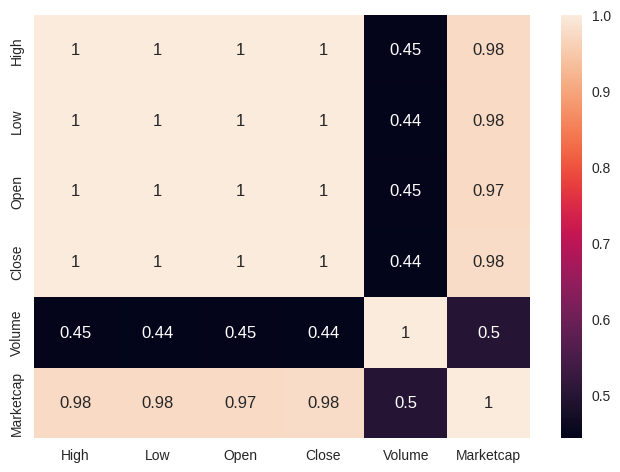

In [57]:
sea.heatmap(test.select_dtypes(exclude='int').corr(),annot=True)

<Axes: >

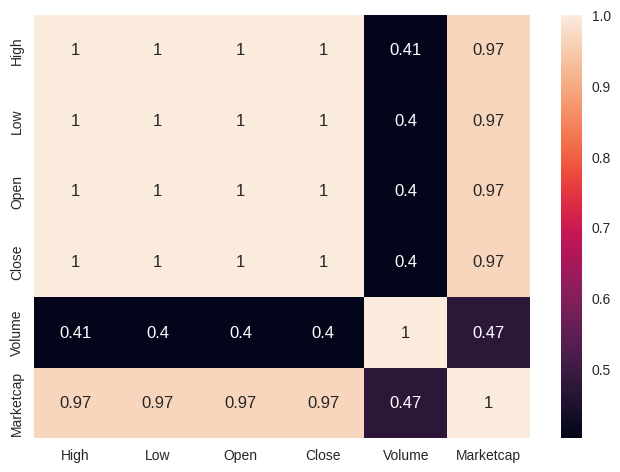

In [58]:
sea.heatmap(train.select_dtypes(exclude='int').corr(),annot=True)

In [59]:
xtrain, xtest, ytrain, ytest = (
    train.drop(columns=['Marketcap'],axis=0).iloc[:,1:],
    test.drop(columns=['Marketcap'],axis=0).iloc[:,1:],
    train['Marketcap'],
    test['Marketcap']
)

In [60]:
pd.concat([ytest.describe(),ytrain.describe()],axis=1)

,Marketcap,Marketcap
count,4706.000000,18824.000000
mean,2.510081,2.126338
std,10.239231,8.361766
min,0.000025,0.000015
25%,0.014549,0.013550
50%,0.127786,0.126748
75%,0.821913,0.827087
max,118.636404,118.294549


&nbsp;

### Gradiente Descente

In [66]:

params = dict(
    alpha    = np.linspace(0.001,0.1,10), 
)

gridGrad = GridSearchCV(SGDRegressor(penalty='l2'),param_grid=params,scoring='r2')
gridGrad.fit(xtrain,ytrain)

print('Melhor Estimador :',gridGrad.best_estimator_)
print('Score            :',gridGrad.best_score_)

Melhor Estimador : SGDRegressor(alpha=0.001)
Score            : 0.9555409363674283


In [67]:
grad =  SGDRegressor(alpha=0.001)
grad.fit(xtrain,ytrain)

SGDRegressor(alpha=0.001)

In [68]:
predGrad = grad.predict(xtest)

In [69]:
print("Mean Absolute error..:",mean_absolute_error(ytest,predGrad))
print("Mean Squared error...:",np.sqrt(mean_squared_error(ytest,predGrad)))
print("r2 score.............:",r2_score(ytest,predGrad))

Mean Absolute error..: 0.932738226966531
Mean Squared error...: 2.715764912522622
r2 score.............: 0.9296373832045068


&nbsp;

### Elastic Net

In [ ]:
ElasticNet()